In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import decoupler as dc
import sc_toolbox
import random
import seaborn.objects as so

In [2]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

sys.path = sys.path + ["/well/immune-rep/users/vbw431/python_utils/"]

In [3]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.ipython.ggplot import image_png

#sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/lib/python3.8/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [4]:
%%R
.libPaths(c(paste0("/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/r_modules"), .libPaths()))

library(tidyverse)
library(Seurat)
library(SCPA)

cur.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/out/"
references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"
com.out = "/well/immune-rep/users/vbw431/Projects/Peppa/reference_combat/"

##plotting
library(ggplot2); theme_set(theme_bw(base_size = 18)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x purrr::%@%()                 masks rlang::%@%()
x lazyeval::as_name()          masks rlang::as_name()
x lazyeval::call_modify()      masks rlang::call_modify()
x lazyeval::call_standardise() masks rlang::call_standardise()
x lazyeval::expr_label()       masks rlang::expr_label()
x lazyeval::expr_text()        masks rlang::expr_text()
x lazyeval::f_env()            masks rlang::f_env()
x lazyeval::f_env<-()          masks rlang::f_env<-()
x lazyeval::f_label()          masks rlang::f_label()
x lazyeval::f_lhs()            masks rlang::f_lhs()
x lazyeval::f_lhs<-()          masks rlang::f_lhs<-()
x lazyeval::f_rhs()            masks rlang::f_rhs()
x lazyeval::f_rhs<-() 

In [5]:
%%R
library(msigdbr)
library(magrittr)

pathways <- c("hallmark", "kegg", "reactome", "biocarta", "gobp")
hkr_sets <- msigdbr("Homo sapiens") %>%
  filter(grepl(paste(pathways, collapse = "|"), gs_name, ignore.case = T)) %>%
  format_pathways()

metabolic_pathways <- paste0(work.dir, "ref_pathways/combined_metabolic_pathways.csv")

In [6]:
%%R 

##load, normalise  and trim to remove pre_treatment replicates and post vaccine samples from azimuth

peppa <- readRDS(paste0(out.dir, "/peppa_pbmc_all.rds"))

##filter pre vaccination samples and pre treatment samples out
peppa <- subset(peppa, subset = Treatment_status != "Pre_treatment")

trim_barcodes <- peppa@meta.data %>% 
  dplyr::select(orig.ident) %>%
  dplyr::filter(grepl("_0|SeuratProject", orig.ident))
table(trim_barcodes)

peppa <- subset(peppa, cells = rownames(trim_barcodes))



In [7]:
%%R
peppa@meta.data$scpa_celltype <- ifelse(grepl("cDC1|cDC2", peppa@meta.data$celltype_consensus.l2), "cDC",
                                             ifelse(grepl("pDC",peppa@meta.data$celltype_consensus.l2), "pDC",
                                             ifelse(grepl("CD8.Naive",peppa@meta.data$celltype_consensus.l2), "CD8 Naive",
                                             ifelse(grepl("CD4.Naive",peppa@meta.data$celltype_consensus.l2), "CD4 Naive",
                                            ifelse(grepl("CD8.TEM|CD8.TEMRA|CD8.TCM|MPECs",peppa@meta.data$celltype_consensus.l2), "CD8 Memory",
                                            ifelse(grepl("CD4.TEM|CD4.TEMRA|CD4.TCM",peppa@meta.data$celltype_consensus.l2), "CD4 Memory",
                                            ifelse(grepl("Treg",peppa@meta.data$celltype_consensus.l2), "CD4 Treg",
                                            ifelse(grepl("gdT",peppa@meta.data$celltype_consensus.l2), "gdT",
                                            ifelse(grepl("MAIT",peppa@meta.data$celltype_consensus.l2), "MAIT",
                                            ifelse(grepl("NK",peppa@meta.data$celltype_consensus.l2), "NK",
                                            ifelse(grepl("B.Naive|B.C|B.U|B.DN",peppa@meta.data$celltype_consensus.l2), "B",
                                            ifelse(grepl("Plasmablast",peppa@meta.data$celltype_consensus.l2), "Plasmablast",
                                            ifelse(grepl("cMono",peppa@meta.data$celltype_consensus.l2), "cMono",
                                            ifelse(grepl("ncMono",peppa@meta.data$celltype_consensus.l2), "ncMono","low frequency others"))))))))))))))



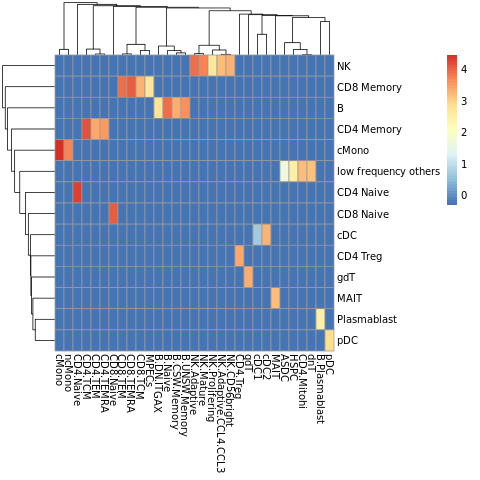

In [8]:
%%R
##plot to sanity check assignments
crosstab <- peppa@meta.data %>%
    select(scpa_celltype, celltype_consensus.l2) %>%
table() 

pheatmap::pheatmap(log10(crosstab+0.5))


In [9]:
%%R
##Normalise data
alldata <- subset(peppa, subset = scpa_celltype != "low frequency others")

alldata <- alldata %>%
  NormalizeData() %>%
  ScaleData()


In [10]:
%%R
parallel::detectCores()

[1] 40


In [11]:
%%R
##perform SCPA on all NKs
alldata <- subset(peppa, subset = scpa_celltype != "low frequency others")

cell_types <- unique(alldata$scpa_celltype)
alldata <- SplitObject(alldata, split.by = "study_disease")


##perform for all pathways
scpa_all <- list()
for (i in cell_types) {
  
  HBV <- seurat_extract(alldata$HBV, 
                            meta1 = "scpa_celltype", value_meta1 = i)
  
  HBV_HIV <- seurat_extract(alldata$HBV_HIV, 
                          meta1 = "scpa_celltype", value_meta1 = i)
  
  print(paste("comparing", i))
  scpa_all[[i]] <- compare_pathways(list(HBV, HBV_HIV), hkr_sets, parallel= TRUE, cores = 20) 

# For faster analysis with parallel processing, use 'parallel = TRUE' and 'cores = x' arguments
  
}




[1] "comparing NK"
[1] "comparing CD8 Memory"
[1] "comparing gdT"
[1] "comparing MAIT"
[1] "comparing CD8 Naive"
[1] "comparing CD4 Naive"
[1] "comparing CD4 Memory"
[1] "comparing CD4 Treg"
[1] "comparing B"
[1] "comparing Plasmablast"
[1] "comparing cMono"
[1] "comparing pDC"
[1] "comparing cDC"


In [12]:
%%R

##perform for metabolic pathways
scpa_metab_all <- list()
for (i in cell_types) {
  
  HBV <- seurat_extract(alldata$HBV, 
                            meta1 = "scpa_celltype", value_meta1 = i)
  
  HBV_HIV <- seurat_extract(alldata$HBV_HIV, 
                          meta1 = "scpa_celltype", value_meta1 = i)
  
  print(paste("comparing", i))
  scpa_metab_all[[i]] <- compare_pathways(list(HBV, HBV_HIV), metabolic_pathways, parallel= TRUE, cores = 20) 

# For faster analysis with parallel processing, use 'parallel = TRUE' and 'cores = x' arguments
  
}


[1] "comparing NK"
[1] "comparing CD8 Memory"
[1] "comparing gdT"
[1] "comparing MAIT"
[1] "comparing CD8 Naive"
[1] "comparing CD4 Naive"
[1] "comparing CD4 Memory"
[1] "comparing CD4 Treg"
[1] "comparing B"
[1] "comparing Plasmablast"
[1] "comparing cMono"
[1] "comparing pDC"
[1] "comparing cDC"


In [13]:
%%R
peppa <- subset(peppa, subset = celltype_consensus.l1 == "NK")

cell_types <- unique(peppa$celltype_consensus.l2)
peppa <- SplitObject(peppa, split.by = "study_disease")

scpa_out <- list()
for (i in cell_types) {
  
  HBV <- seurat_extract(peppa$HBV, 
                            meta1 = "celltype_consensus.l2", value_meta1 = i)
  
  HBV_HIV <- seurat_extract(peppa$HBV_HIV, 
                          meta1 = "celltype_consensus.l2", value_meta1 = i)
  
  print(paste("comparing", i))
  scpa_out[[i]] <- compare_pathways(list(HBV, HBV_HIV), hkr_sets, parallel= TRUE, cores = 8) 

# For faster analysis with parallel processing, use 'parallel = TRUE' and 'cores = x' arguments
  
}

[1] "comparing NK.Adaptive.CCL4.CCL3"
[1] "comparing NK.Adaptive"
[1] "comparing NK.Mature"
[1] "comparing NK.CD56bright"
[1] "comparing NK.Prolifering"


In [14]:
%%R
scpa_metab_out <- list()
for (i in cell_types) {
  
  HBV <- seurat_extract(peppa$HBV, 
                            meta1 = "celltype_consensus.l2", value_meta1 = i)
  
  HBV_HIV <- seurat_extract(peppa$HBV_HIV, 
                          meta1 = "celltype_consensus.l2", value_meta1 = i)
  
  print(paste("comparing", i))
  scpa_metab_out[[i]] <- compare_pathways(list(HBV, HBV_HIV), metabolic_pathways, parallel= TRUE, cores = 8) 

# For faster analysis with parallel processing, use 'parallel = TRUE' and 'cores = x' arguments
  
}

[1] "comparing NK.Adaptive.CCL4.CCL3"
[1] "comparing NK.Adaptive"
[1] "comparing NK.Mature"
[1] "comparing NK.CD56bright"
[1] "comparing NK.Prolifering"


In [15]:
%%R
saveRDS(scpa_all, paste0(out.dir, "/scpa_all.rds"))
saveRDS(scpa_metab_all, paste0(out.dir, "/scpa_metab_all.rds"))
saveRDS(scpa_out, paste0(out.dir, "/scpa_subset.rds"))
saveRDS(scpa_metab_out, paste0(out.dir, "/scpa_metab_subset.rds"))